<a href="https://colab.research.google.com/github/LeonGoergen/DocumentClassification/blob/main/classification/Neural_Network_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The [Keras Documentation](https://keras.io/api/) will give a comprehensive overview on the different layers and hyperparameters.

# Dependencies

## Imports

In [ ]:
# Text Encoding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences

# Neural Network Layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, Conv1D, MaxPooling1D, GRU, Bidirectional
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint,  Callback
from keras.layers import Dropout

# For Data Management
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
import pickle
import json

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import time

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Bachelor Thesis/Datasets/train.csv', sep="\t", header=0)
test = pd.read_csv('/content/drive/MyDrive/Bachelor Thesis/Datasets/test.csv', sep="\t", header=0)

In [ ]:
label_target = 'Product'
content_target = 'Consumer complaint narrative'

num_labels = train[label_target].nunique()

## Functions

In [ ]:
def calculate_accuracy(y_actu, y_pred):
    return accuracy_score(y_actu, y_pred)

def calculate_precision(y_actu, y_pred,average='macro'):
    return precision_score(y_actu, y_pred,average=average)

def calculate_recall(y_actu, y_pred,average='macro'):
    return recall_score(y_actu, y_pred,average=average)

def calculate_f1(y_actu, y_pred,average='macro'):
    return f1_score(y_actu, y_pred,average=average)

def save_results(metrics, algorithm, method):
    name = "/content/drive/MyDrive/Bachelor Thesis/Classification/Results/" + algorithm + method + ".json"
    with open(name, "w") as outfile:
        json.dump(metrics, outfile)

def evaluate_model(y_actu, y_pred, time, training_time, algorithm, method=""):
    metrics = {}
    metrics["Algorithm"] = algorithm
    metrics["Method"] = method
    metrics["Accuracy"] = round(calculate_accuracy(y_actu, y_pred)*100, 4)
    metrics["Precision (Macro Average)"] = round(calculate_precision(y_actu, y_pred,average='macro')*100, 4)
    metrics["Precision (Micro Average)"] = round(calculate_precision(y_actu, y_pred,average='micro')*100, 4)
    metrics["Recall (Macro Average)"] = round(calculate_recall(y_actu, y_pred,average='macro')*100, 4)
    metrics["Recall (Micro Average)"] = round(calculate_recall(y_actu, y_pred,average='micro')*100, 4)
    metrics["F1-Score (Macro Average)"] = round(calculate_f1(y_actu, y_pred,average='macro')*100, 4)
    metrics["F1-Score (Micro Average)"] = round(calculate_f1(y_actu, y_pred,average='micro')*100, 4)
    metrics["time per document (ms)"] = time
    metrics["training time (min)"] = training_time

    save_results(metrics, algorithm, method)

    return metrics

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

# LSTM
Long short-term memory networks

## Setup Data

In [ ]:
tokenizer = Tokenizer(num_words=10000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train[content_target].values.astype("str"))

sequences = tokenizer.texts_to_sequences(train[content_target].values.astype("str"))
padded = pad_sequences(sequences, maxlen=512)

labels = pd.get_dummies(train[label_target]).values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(padded, labels, test_size = 0.15, random_state = 1)

## Train Model

In [ ]:
model = Sequential()
model.add(Embedding(10000, 100, input_length=padded.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 512, 100)          1000000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 512, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 128)               117248    
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1,118,538
Trainable params: 1,118,538
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 30
batch_size = 64

start = time.time()
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
training_time = time.time() - start

print(training_time)

Epoch 1/30
958/958 [==============================] - 1704s 2s/step - loss: 1.6144 - accuracy: 0.3935 - val_loss: 1.2323 - val_accuracy: 0.5410
Epoch 2/30
958/958 [==============================] - 1715s 2s/step - loss: 1.1449 - accuracy: 0.5977 - val_loss: 1.0900 - val_accuracy: 0.6412
Epoch 3/30
958/958 [==============================] - 1716s 2s/step - loss: 1.0958 - accuracy: 0.6187 - val_loss: 1.0473 - val_accuracy: 0.6443
Epoch 4/30
958/958 [==============================] - 1724s 2s/step - loss: 0.8581 - accuracy: 0.7107 - val_loss: 0.8815 - val_accuracy: 0.6967
Epoch 5/30
958/958 [==============================] - 1739s 2s/step - loss: 0.7697 - accuracy: 0.7366 - val_loss: 0.8843 - val_accuracy: 0.7049
Epoch 6/30
958/958 [==============================] - 1734s 2s/step - loss: 0.9423 - accuracy: 0.6856 - val_loss: 1.1597 - val_accuracy: 0.6193
Epoch 7/30
958/958 [==============================] - 1729s 2s/step - loss: 0.7503 - accuracy: 0.7434 - val_loss: 0.8374 - val_accuracy:

In [ ]:
model.save('/content/lstm')
!zip -r '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/lstm_model_nolemma.zip' '/content/lstm'
with open('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/lstm_tokenizer_nolemma.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  adding: content/lstm/ (stored 0%)
  adding: content/lstm/saved_model.pb (deflated 89%)
  adding: content/lstm/keras_metadata.pb (deflated 87%)
  adding: content/lstm/assets/ (stored 0%)
  adding: content/lstm/variables/ (stored 0%)
  adding: content/lstm/variables/variables.index (deflated 60%)
  adding: content/lstm/variables/variables.data-00000-of-00001 (deflated 7%)


### Evaluate Training

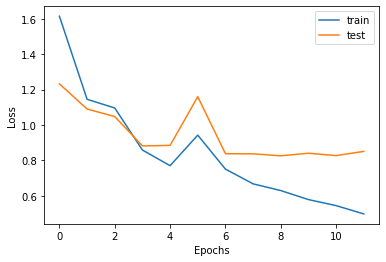

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Inference

In [ ]:
with open('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/lstm_tokenizer_nolemma.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)
!unzip -u "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/lstm_model_nolemma.zip" -d "/content/"
model = keras.models.load_model('/content/content/lstm')

Archive:  /content/drive/MyDrive/Bachelor Thesis/Classification/Models/lstm_model_nolemma.zip
   creating: /content/content/lstm/
  inflating: /content/content/lstm/saved_model.pb  
  inflating: /content/content/lstm/keras_metadata.pb  
   creating: /content/content/lstm/assets/
   creating: /content/content/lstm/variables/
  inflating: /content/content/lstm/variables/variables.index  
  inflating: /content/content/lstm/variables/variables.data-00000-of-00001  


In [ ]:
labels = sorted(test[label_target].unique())
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    # get text
    new_text = [row[content_target]]

    # tokenize and pad it
    seq = tokenizer.texts_to_sequences(new_text)
    padded = pad_sequences(seq, maxlen=512)

    # predict the label
    pred = model.predict(padded, verbose = 0)
    pred_cat = labels[np.argmax(pred)]

    # sort into lists
    y_actu.append(row[label_target])
    y_pred.append(pred_cat)
    predictions.append([pred_cat, row[label_target], row[content_target], row['Complaint ID']])

full_time = time.time() - start_time

100%|██████████| 14139/14139 [27:07<00:00,  8.69it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "LSTM")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,LSTM
1,Method,
2,Accuracy,73.9232
3,Precision (Macro Average),73.7958
4,Precision (Micro Average),73.9232
5,Recall (Macro Average),73.8656
6,Recall (Micro Average),73.9232
7,F1-Score (Macro Average),73.7523
8,F1-Score (Micro Average),73.9232
9,time per document (ms),115.08


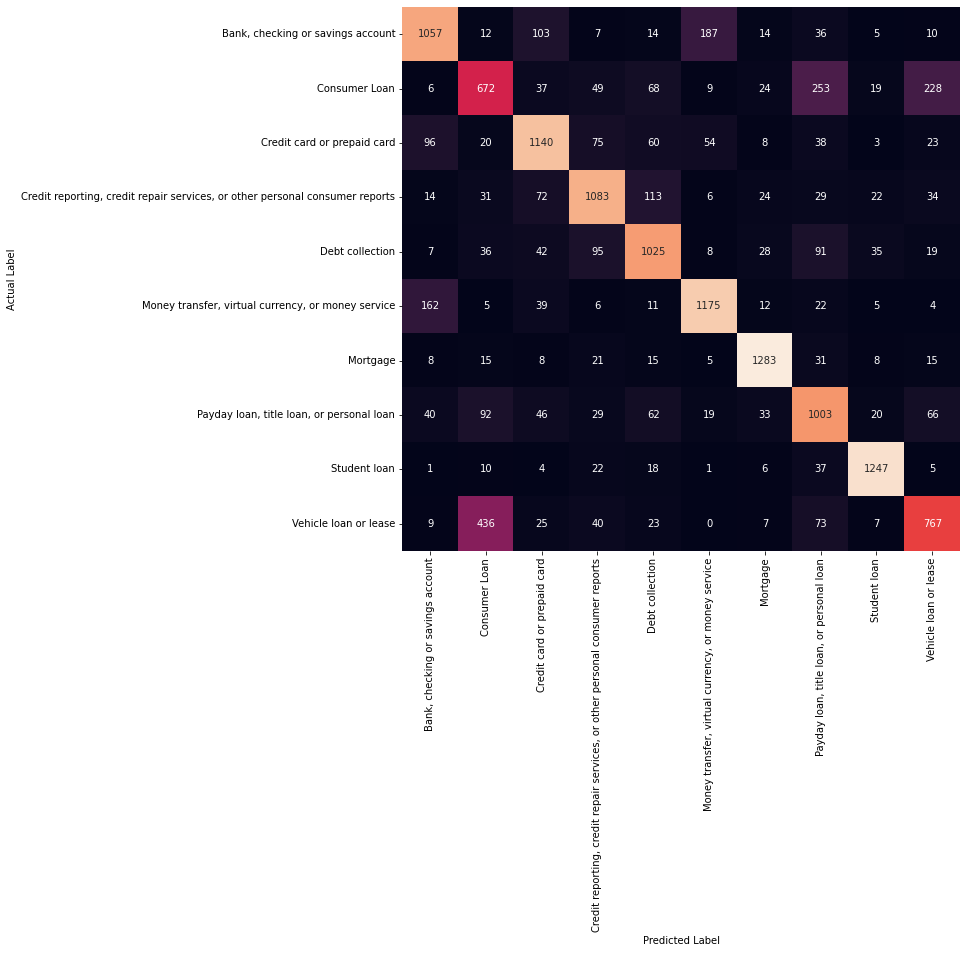

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

# Bi-LSTM
Bidirectional long-short term memory

## Setup Data

In [ ]:
most_frequent = 10000
max_length = 512

In [ ]:
tokenizer = Tokenizer(num_words=most_frequent, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train[content_target].values.astype("str"))

sequences = tokenizer.texts_to_sequences(train[content_target].values.astype("str"))
padded = pad_sequences(sequences, maxlen=max_length)

labels = pd.get_dummies(train[label_target]).values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(padded, labels, test_size = 0.15, random_state = 1)

## Train Model

In [ ]:
model = Sequential()
model.add(Embedding(most_frequent, 32, input_length = padded.shape[1]))
model.add(Bidirectional(LSTM(128, return_sequences = False)))
model.add(Dropout(0.2))
model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              164864    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
Total params: 487,434
Trainable params: 487,434
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 30
batch_size = 64

start = time.time()
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
training_time = time.time() - start

print(training_time)

Epoch 1/30
958/958 [==============================] - 1637s 2s/step - loss: 1.6725 - accuracy: 0.3511 - val_loss: 1.5188 - val_accuracy: 0.4111
Epoch 2/30
958/958 [==============================] - 1635s 2s/step - loss: 1.2738 - accuracy: 0.5539 - val_loss: 1.5906 - val_accuracy: 0.4725
Epoch 3/30
958/958 [==============================] - 1630s 2s/step - loss: 1.1179 - accuracy: 0.6159 - val_loss: 1.0439 - val_accuracy: 0.6434
Epoch 4/30
958/958 [==============================] - 1632s 2s/step - loss: 1.0435 - accuracy: 0.6431 - val_loss: 0.9991 - val_accuracy: 0.6438
Epoch 5/30
958/958 [==============================] - 1631s 2s/step - loss: 0.8732 - accuracy: 0.7028 - val_loss: 0.9486 - val_accuracy: 0.6771
Epoch 6/30
958/958 [==============================] - 1631s 2s/step - loss: 0.8158 - accuracy: 0.7233 - val_loss: 0.9257 - val_accuracy: 0.6987
Epoch 7/30
958/958 [==============================] - 1637s 2s/step - loss: 0.7433 - accuracy: 0.7471 - val_loss: 0.8671 - val_accuracy:

In [ ]:
model.save('/content/bilstm')
!zip -r '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/bilstm_model_nolemma.zip' '/content/bilstm'
with open('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/bilstm_tokenizer_nolemma.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  adding: content/bilstm/ (stored 0%)
  adding: content/bilstm/saved_model.pb (deflated 91%)
  adding: content/bilstm/keras_metadata.pb (deflated 89%)
  adding: content/bilstm/assets/ (stored 0%)
  adding: content/bilstm/variables/ (stored 0%)
  adding: content/bilstm/variables/variables.index (deflated 65%)
  adding: content/bilstm/variables/variables.data-00000-of-00001 (deflated 7%)


### Evaluate Training

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Inference

In [ ]:
with open('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/bilstm_tokenizer_nolemma.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)
!unzip -u "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/bilstm_model_nolemma.zip" -d "/content/"
model = keras.models.load_model('/content/content/bilstm')

Archive:  /content/drive/MyDrive/Bachelor Thesis/Classification/Models/bilstm_model_nolemma.zip


In [ ]:
labels = sorted(test[label_target].unique())
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    # get text
    new_text = [row[content_target]]

    # tokenize and pad it
    seq = tokenizer.texts_to_sequences(new_text)
    padded = pad_sequences(seq, maxlen=512)

    # predict the label
    pred = model.predict(padded, verbose = 0)
    pred_cat = labels[np.argmax(pred)]

    # sort into lists
    y_actu.append(row[label_target])
    y_pred.append(pred_cat)
    predictions.append([pred_cat, row[label_target], row[content_target], row['Complaint ID']])

full_time = time.time() - start_time

100%|██████████| 14139/14139 [21:49<00:00, 10.80it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "Bi-LSTM")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,Bi-LSTM
1,Method,
2,Accuracy,72.9613
3,Precision (Macro Average),72.8388
4,Precision (Micro Average),72.9613
5,Recall (Macro Average),72.9275
6,Recall (Micro Average),72.9613
7,F1-Score (Macro Average),72.8217
8,F1-Score (Micro Average),72.9613
9,time per document (ms),127.37


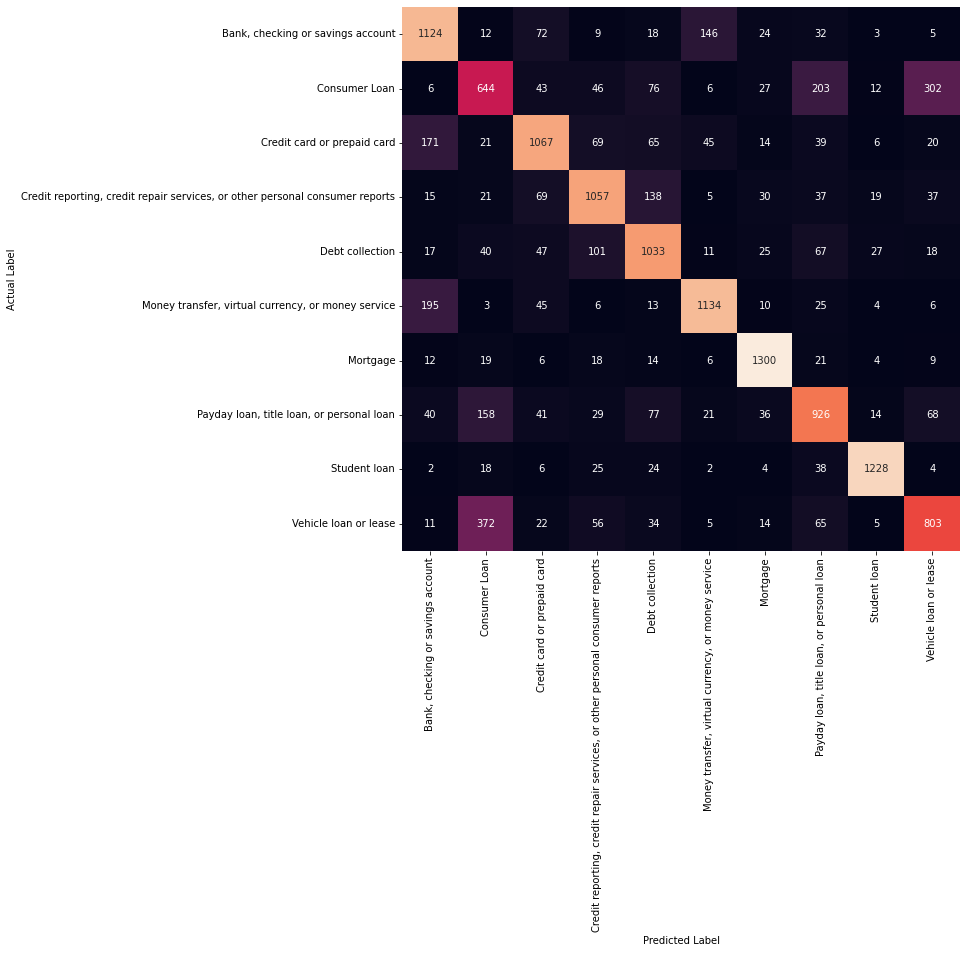

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

# GRU
Gated recurrent unit

## Setup Data

In [ ]:
most_frequent = 10000
max_length = 512

In [ ]:
tokenizer = Tokenizer(num_words=most_frequent, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train[content_target].values.astype("str"))

sequences = tokenizer.texts_to_sequences(train[content_target].values.astype("str"))
padded = pad_sequences(sequences, maxlen=max_length)

labels = pd.get_dummies(train[label_target]).values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(padded, labels, test_size = 0.15, random_state = 1)

## Train Model

In [ ]:
model = Sequential()
model.add(Embedding(most_frequent, 32, input_length = padded.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(GRU(128, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(num_labels, activation = 'softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 32)           320000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 512, 32)          0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 128)               62208     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 383,498
Trainable params: 383,498
Non-trainable params: 0
__________________________________________________

In [ ]:
epochs = 30
batch_size = 64

start = time.time()
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
training_time = time.time() - start

print(training_time)

Epoch 1/30
958/958 [==============================] - 789s 821ms/step - loss: 1.4270 - accuracy: 0.4653 - val_loss: 0.9382 - val_accuracy: 0.6820
Epoch 2/30
958/958 [==============================] - 782s 817ms/step - loss: 0.8510 - accuracy: 0.7047 - val_loss: 0.8290 - val_accuracy: 0.7067
Epoch 3/30
958/958 [==============================] - 780s 814ms/step - loss: 0.7478 - accuracy: 0.7404 - val_loss: 0.8097 - val_accuracy: 0.7215
Epoch 4/30
958/958 [==============================] - 791s 826ms/step - loss: 0.6834 - accuracy: 0.7624 - val_loss: 0.7884 - val_accuracy: 0.7334
Epoch 5/30
958/958 [==============================] - 787s 821ms/step - loss: 0.6382 - accuracy: 0.7782 - val_loss: 0.7995 - val_accuracy: 0.7379
Epoch 6/30
958/958 [==============================] - 776s 810ms/step - loss: 0.5932 - accuracy: 0.7954 - val_loss: 0.7949 - val_accuracy: 0.7394
Epoch 7/30
958/958 [==============================] - 787s 822ms/step - loss: 0.5499 - accuracy: 0.8115 - val_loss: 0.8012 -

In [ ]:
model.save('/content/gru')
!zip -r '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/gru_model_nolemma.zip' '/content/gru'
with open('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/gru_tokenizer_nolemma.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  adding: content/gru/ (stored 0%)
  adding: content/gru/assets/ (stored 0%)
  adding: content/gru/saved_model.pb (deflated 89%)
  adding: content/gru/variables/ (stored 0%)
  adding: content/gru/variables/variables.index (deflated 61%)
  adding: content/gru/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/gru/keras_metadata.pb (deflated 87%)


### Evaluate Training

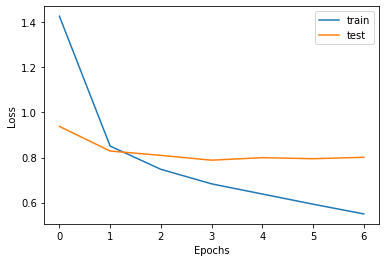

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Inference

In [ ]:
with open('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/gru_tokenizer_nolemma.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)
!unzip -u "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/gru_model_nolemma.zip" -d "/content/"
model = keras.models.load_model('/content/content/gru')

Archive:  /content/drive/MyDrive/Bachelor Thesis/Classification/Models/gru_model_nolemma.zip


In [ ]:
labels = sorted(test[label_target].unique())
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    # get text
    new_text = [row[content_target]]

    # tokenize and pad it
    seq = tokenizer.texts_to_sequences(new_text)
    padded = pad_sequences(seq, maxlen=512)

    # predict the label
    pred = model.predict(padded, verbose = 0)
    pred_cat = labels[np.argmax(pred)]

    # sort into lists
    y_actu.append(row[label_target])
    y_pred.append(pred_cat)
    predictions.append([pred_cat, row[label_target], row[content_target], row['Complaint ID']])

full_time = time.time() - start_time

100%|██████████| 14139/14139 [16:51<00:00, 13.98it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "GRU")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,GRU
1,Method,
2,Accuracy,74.6658
3,Precision (Macro Average),74.4319
4,Precision (Micro Average),74.6658
5,Recall (Macro Average),74.5952
6,Recall (Micro Average),74.6658
7,F1-Score (Macro Average),74.0911
8,F1-Score (Micro Average),74.6658
9,time per document (ms),71.55


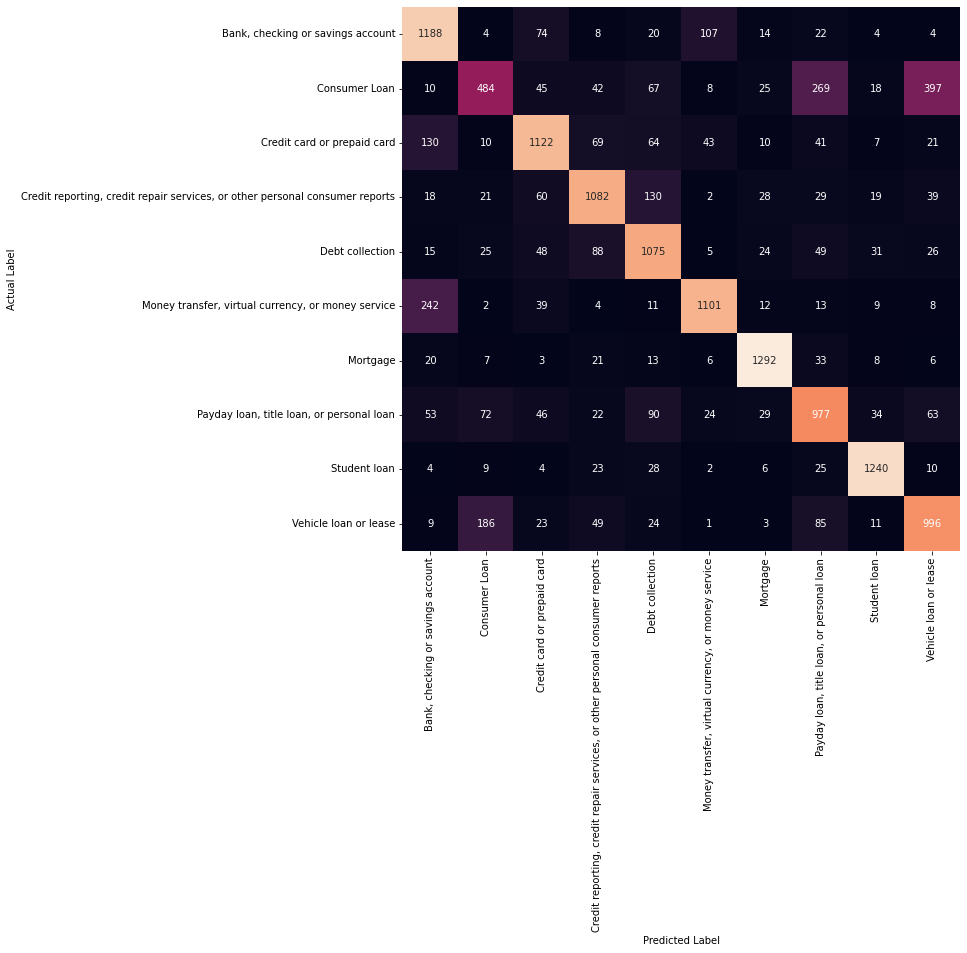

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

# CNN
Convolutional neural network

## Setup Data

In [ ]:
most_frequent = 10000
max_length = 512

In [ ]:
tokenizer = Tokenizer(num_words=most_frequent, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train[content_target].values.astype("str"))

sequences = tokenizer.texts_to_sequences(train[content_target].values.astype("str"))
padded = pad_sequences(sequences, maxlen=max_length)

labels = pd.get_dummies(train[label_target]).values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(padded, labels, test_size = 0.15, random_state = 1)

## Train Model

In [ ]:
model = Sequential()
model.add(Embedding(most_frequent, 32, input_length=padded.shape[1]))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 32)           320000    
                                                                 
 conv1d_1 (Conv1D)           (None, 512, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 256, 32)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 250)               2048250   
                                                                 
 dense_4 (Dense)             (None, 10)                2510      
                                                      

In [ ]:
epochs = 30
batch_size = 64

start = time.time()
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
training_time = time.time() - start

print(training_time)

Epoch 1/30
958/958 [==============================] - 71s 74ms/step - loss: 1.1176 - accuracy: 0.6025 - val_loss: 0.8634 - val_accuracy: 0.7052
Epoch 2/30
958/958 [==============================] - 65s 68ms/step - loss: 0.7035 - accuracy: 0.7574 - val_loss: 0.8260 - val_accuracy: 0.7247
Epoch 3/30
958/958 [==============================] - 67s 70ms/step - loss: 0.5495 - accuracy: 0.8110 - val_loss: 0.8813 - val_accuracy: 0.7112
Epoch 4/30
958/958 [==============================] - 65s 68ms/step - loss: 0.4135 - accuracy: 0.8600 - val_loss: 0.9605 - val_accuracy: 0.7125
Epoch 5/30
958/958 [==============================] - 65s 68ms/step - loss: 0.2931 - accuracy: 0.9027 - val_loss: 1.1699 - val_accuracy: 0.6934
333.74945974349976


In [ ]:
model.save('/content/cnn')
!zip -r '/content/drive/MyDrive/Bachelor Thesis/Classification/Models/cnn_model_nolemma.zip' '/content/cnn'
with open('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/cnn_tokenizer_nolemma.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

updating: content/cnn/ (stored 0%)
updating: content/cnn/assets/ (stored 0%)
updating: content/cnn/saved_model.pb (deflated 87%)
updating: content/cnn/variables/ (stored 0%)
updating: content/cnn/variables/variables.index (deflated 62%)
updating: content/cnn/variables/variables.data-00000-of-00001 (deflated 9%)
updating: content/cnn/keras_metadata.pb (deflated 88%)


### Evaluate Training

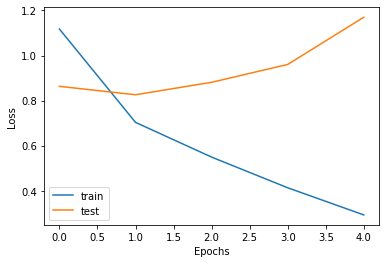

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Inference

In [ ]:
with open('/content/drive/MyDrive/Bachelor Thesis/Classification/Models/cnn_tokenizer_nolemma.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)
!unzip -u "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/cnn_model_nolemma.zip" -d "/content/"
model = keras.models.load_model('/content/content/cnn')

Archive:  /content/drive/MyDrive/Bachelor Thesis/Classification/Models/cnn_model_nolemma.zip
replace /content/content/cnn/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/content/cnn/saved_model.pb  
replace /content/content/cnn/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/content/cnn/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/content/cnn/variables/variables.index  
  inflating: /content/content/cnn/variables/variables.data-00000-of-00001  
  inflating: /content/content/cnn/keras_metadata.pb  


In [ ]:
labels = sorted(test[label_target].unique())
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    # get text
    new_text = [row[content_target]]

    # tokenize and pad it
    seq = tokenizer.texts_to_sequences(new_text)
    padded = pad_sequences(seq, maxlen=512)

    # predict the label
    pred = model.predict(padded, verbose = 0)
    pred_cat = labels[np.argmax(pred)]

    # sort into lists
    y_actu.append(row[label_target])
    y_pred.append(pred_cat)
    predictions.append([pred_cat, row[label_target], row[content_target], row['Complaint ID']])

full_time = time.time() - start_time

100%|██████████| 14139/14139 [11:36<00:00, 20.31it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluation

In [ ]:
print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "CNN")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,CNN
1,Method,
2,Accuracy,71.0305
3,Precision (Macro Average),71.2331
4,Precision (Micro Average),71.0305
5,Recall (Macro Average),71.0052
6,Recall (Micro Average),71.0305
7,F1-Score (Macro Average),70.9676
8,F1-Score (Micro Average),71.0305
9,time per document (ms),49.24


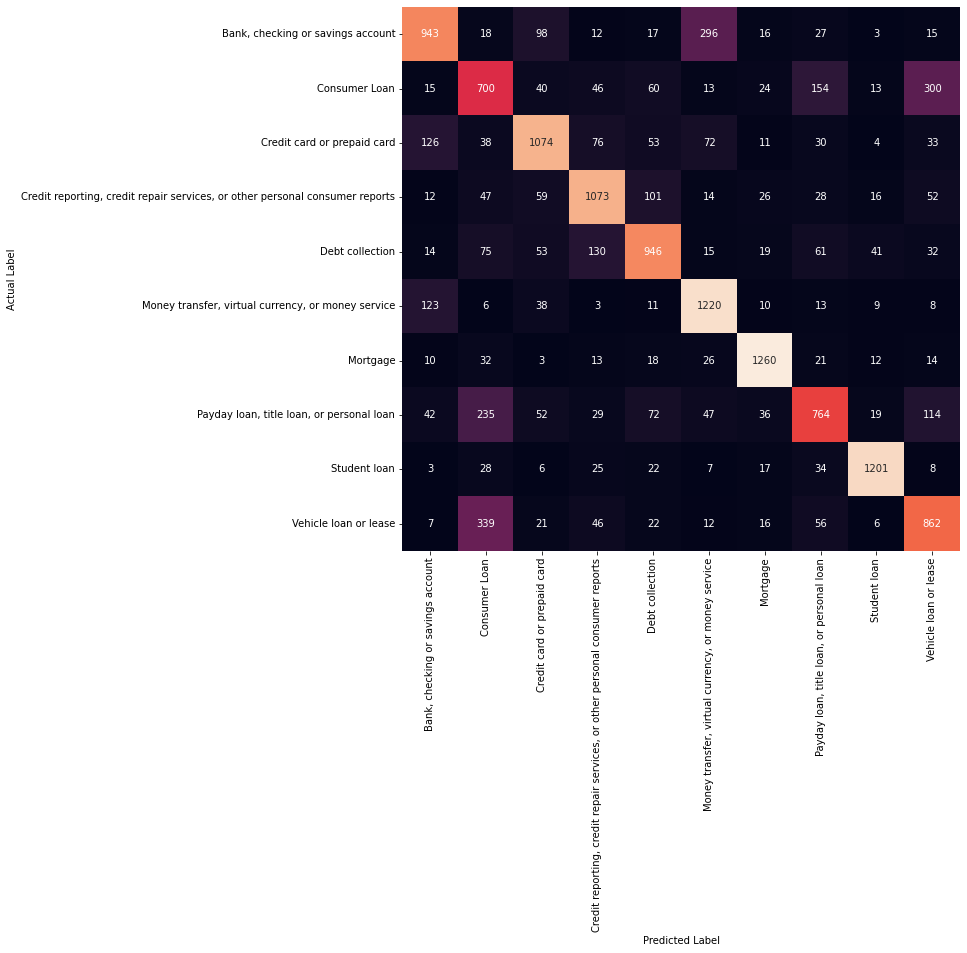

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)